# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

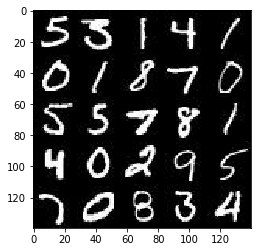

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

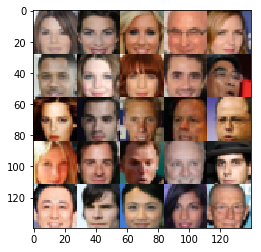

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # 28x28x3 to start
        # extra zeros padding for 2nd and 3rd dims
        extra_padding = [[0,0], [2,2], [2,2], [0,0]]
        resized = tf.pad(images[1:], extra_padding, 'CONSTANT')
        # 32x32x3 now
     
        # convolutional to make smaller/deeper, first layer has no batch normalization
        conv1 = tf.layers.conv2d(resized, 64, kernel_size=5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 16x16x64 now
        #print('conv1.shape', conv1.shape)

        # convolutional to make smaller/deeper
        conv2 = tf.layers.conv2d(conv1, 128, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 8x8x128 now
        #print('conv2.shape', conv2.shape)
        
        # convolutional to make smaller/deeper
        conv3 = tf.layers.conv2d(conv2, 256, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 4x4x256 now
        #print('conv3.shape', conv3.shape)
        
        ### final fully connected layer
        # reshape to flat with same number of values
        flat = tf.reshape(conv3, (-1, 4*4*256))
        # turn this into a fully connected layer with 1 unit
        logits = tf.layers.dense(flat, 1, activation=None)
        # adding dropout to make discrim less powerful than generator
        logits = tf.layers.dropout(logits, rate=0.4)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # size z to start
        # project to greater number of units
        fc1 = tf.layers.dense(z, 2*2*512, activation=None)
        # reshape to desired size
        fc1 = tf.reshape(fc1, (-1, 2, 2, 512))
        # add batch normalization
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        # add leaky relu
        fc1 = tf.maximum(alpha * fc1, fc1)
        #print('fc1.shape', fc1.shape)
        # 2x2x512 now
        
        # convolutional transpose to make wider/shallower
        conv1 = tf.layers.conv2d_transpose(fc1, 256, kernel_size=5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        #print('conv1.shape', conv1.shape)
        # 4x4x256 now

        # convolutional transpose to make wider/shallower
        conv2 = tf.layers.conv2d_transpose(conv1, 128, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print('conv2.shape', conv2.shape)
        # 8x8x128 now

        # convolutional transpose to make wider/shallower
        conv3 = tf.layers.conv2d_transpose(conv2, 64, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #print('conv3.shape', conv3.shape)
        # 16x16x64 now

        # convolutional transpose to make wider/shallower, match output image size
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 32x32x out_channel_dim now
        logits = tf.image.resize_nearest_neighbor(logits, [28, 28])
        # 28x28x out_channel_dim now
        out = tf.tanh(logits)
        
        # per docs, this should work for 4D, but errors with tf v1.7.0
        # test = tf.image.resize_image_with_crop_or_pad(logits, 28, 28)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # build the generator
    g_out = generator(input_z, out_channel_dim, is_train=True)
    # build the discriminator for real data
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    # build the discriminator for fake data, reusing the same weights as the real
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    # get the discriminator loss with real data, labels are ones since real
    # smoothing done only to discriminator to improve it's generalization
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_out_real) * (1-smooth)))
    # get the discriminator loss with fake data, labels are zeros since fake
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_out_fake)))
    # total discriminator loss
    d_loss = d_loss_fake + d_loss_real
    
    # generator loss with fake data, labels are ones since g is trying to trick d
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss=d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(loss=g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # take learning_rate param, assign to lr_value to be passed in feed_dict
    lr_value = learning_rate
    
    # Set up model via: inputs, loss, and optimizer
    #print('data_shape', data_shape)
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Do the training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step, sample_num = 0, 0
        samples = np.zeros((64, 28, 28, 3))
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                # Get random data to input into generator
                batch_z = np.random.normal(loc=0, scale=1, size=[batch_size, z_dim])
                
                # rescale batch images from (-.5, .5) to (-1, 1)
                batch_images = batch_images * 2
                
                #print('batch_z.shape', batch_z.shape)
                #size=(batch_size, z_dim): batch_z.shape (32, 100)
                #[batch_size, z_dim]: batch_z.shape (32, 100)

                # Run the model for the generator and discriminator
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images,
                                               learning_rate: lr_value})
                _ = sess.run(d_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images,
                                               learning_rate: lr_value})
                
                # Print status
                if step % 20 == 0:
                    g_loss_eval = g_loss.eval(feed_dict={input_z: batch_z,
                                                         learning_rate: lr_value})
                    d_loss_eval = d_loss.eval(feed_dict={input_z: batch_z,
                                                         input_real: batch_images,
                                                         learning_rate: lr_value})
                    print('Epoch: {}, Step: {},'.format(epoch_i+1, step),
                          'G loss: {:.4f}...'.format(g_loss_eval),
                          'D loss: {:.4f}'.format(d_loss_eval))
                if step % 400 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                # build figure grid of progressive samples
                if step % 95 == 0 and sample_num < samples.shape[0] and data_image_mode == 'RGB':
                    example_z = np.random.normal(loc=0, scale=1, size=[1, z_dim])
                    
                    # run the generator and add to array of samples
                    sample = sess.run(
                        generator(input_z, data_shape[3], False),
                        feed_dict={input_z: example_z})
                    samples[sample_num] = sample
                    
                    # plot the figure
                    if sample_num == samples.shape[0]-1:
                        cmap = None if data_image_mode == 'RGB' else 'gray'
                        images_grid = helper.images_square_grid(samples, data_image_mode)
                        figure = pyplot.figure(figsize=(18,18))
                        axis = figure.add_subplot(2,2,1)
                        axis.imshow(images_grid, cmap=cmap)
                        pyplot.show() 
                    sample_num += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1, Step: 20, G loss: 2.5580... D loss: 1.5956
Epoch: 1, Step: 40, G loss: 1.9023... D loss: 1.1471
Epoch: 1, Step: 60, G loss: 1.2354... D loss: 1.1433
Epoch: 1, Step: 80, G loss: 2.3129... D loss: 0.6595
Epoch: 1, Step: 100, G loss: 2.7924... D loss: 0.5949


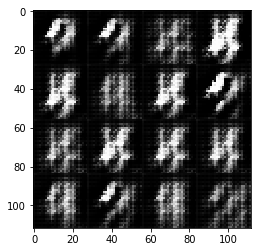

Epoch: 1, Step: 120, G loss: 1.3568... D loss: 0.8872
Epoch: 1, Step: 140, G loss: 2.2037... D loss: 0.5446
Epoch: 1, Step: 160, G loss: 1.6821... D loss: 0.6145
Epoch: 1, Step: 180, G loss: 2.0480... D loss: 0.7061
Epoch: 1, Step: 200, G loss: 2.0131... D loss: 0.7529


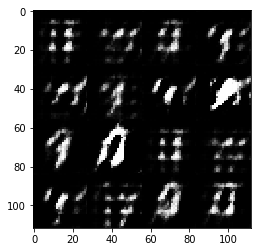

Epoch: 1, Step: 220, G loss: 1.6710... D loss: 0.6498
Epoch: 1, Step: 240, G loss: 1.5664... D loss: 0.7185
Epoch: 1, Step: 260, G loss: 0.9979... D loss: 0.9771
Epoch: 1, Step: 280, G loss: 1.5732... D loss: 0.8910
Epoch: 1, Step: 300, G loss: 1.5861... D loss: 0.7923


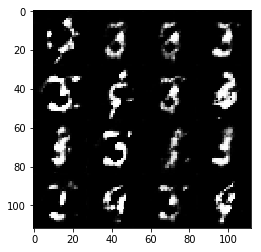

Epoch: 1, Step: 320, G loss: 2.4386... D loss: 0.8939
Epoch: 1, Step: 340, G loss: 1.1122... D loss: 0.8026
Epoch: 1, Step: 360, G loss: 1.4996... D loss: 0.7781
Epoch: 1, Step: 380, G loss: 1.8340... D loss: 0.9300
Epoch: 1, Step: 400, G loss: 0.7441... D loss: 1.1380


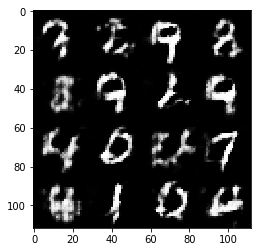

Epoch: 1, Step: 420, G loss: 1.0733... D loss: 0.9274
Epoch: 1, Step: 440, G loss: 1.8039... D loss: 0.8694
Epoch: 1, Step: 460, G loss: 2.3002... D loss: 0.9701
Epoch: 1, Step: 480, G loss: 1.3891... D loss: 1.0069
Epoch: 1, Step: 500, G loss: 1.8007... D loss: 1.2061


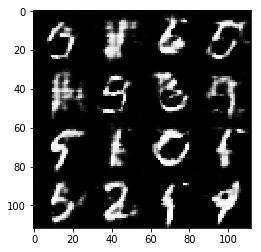

Epoch: 1, Step: 520, G loss: 2.0354... D loss: 1.0079
Epoch: 1, Step: 540, G loss: 1.6910... D loss: 1.0307
Epoch: 1, Step: 560, G loss: 1.4038... D loss: 1.0183
Epoch: 1, Step: 580, G loss: 1.2334... D loss: 1.0437
Epoch: 1, Step: 600, G loss: 1.8091... D loss: 1.2022


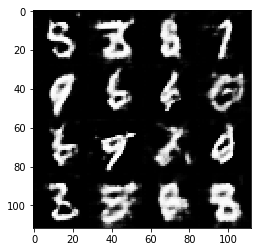

Epoch: 1, Step: 620, G loss: 0.9017... D loss: 0.9814
Epoch: 1, Step: 640, G loss: 1.6265... D loss: 1.1181
Epoch: 1, Step: 660, G loss: 1.3529... D loss: 0.9723
Epoch: 1, Step: 680, G loss: 0.7936... D loss: 1.1744
Epoch: 1, Step: 700, G loss: 1.4554... D loss: 1.0500


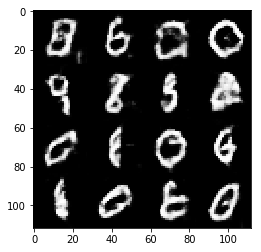

Epoch: 1, Step: 720, G loss: 0.7124... D loss: 1.2123
Epoch: 1, Step: 740, G loss: 0.8288... D loss: 1.1247
Epoch: 1, Step: 760, G loss: 0.8640... D loss: 1.0931
Epoch: 1, Step: 780, G loss: 0.6758... D loss: 1.1875
Epoch: 1, Step: 800, G loss: 0.9936... D loss: 1.1084


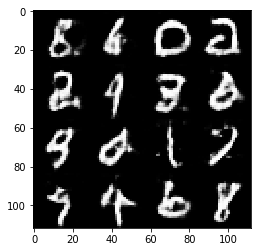

Epoch: 1, Step: 820, G loss: 1.0928... D loss: 0.9914
Epoch: 1, Step: 840, G loss: 1.1006... D loss: 1.0145
Epoch: 1, Step: 860, G loss: 1.0358... D loss: 1.0342
Epoch: 1, Step: 880, G loss: 1.3152... D loss: 1.1009
Epoch: 1, Step: 900, G loss: 1.2525... D loss: 1.0384


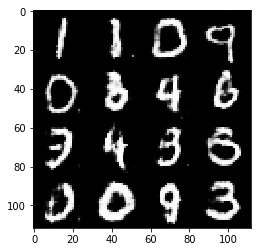

Epoch: 1, Step: 920, G loss: 0.9252... D loss: 1.2212
Epoch: 2, Step: 940, G loss: 1.0341... D loss: 1.0829
Epoch: 2, Step: 960, G loss: 1.0743... D loss: 1.0865
Epoch: 2, Step: 980, G loss: 0.9824... D loss: 1.0811
Epoch: 2, Step: 1000, G loss: 1.0727... D loss: 1.0960


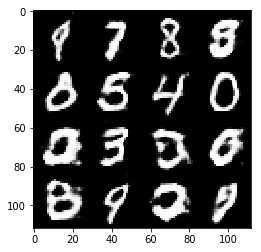

Epoch: 2, Step: 1020, G loss: 1.1748... D loss: 1.1133
Epoch: 2, Step: 1040, G loss: 0.6068... D loss: 1.3939
Epoch: 2, Step: 1060, G loss: 0.9657... D loss: 1.1832
Epoch: 2, Step: 1080, G loss: 0.7335... D loss: 1.1878
Epoch: 2, Step: 1100, G loss: 1.0006... D loss: 1.1785


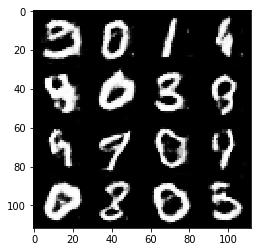

Epoch: 2, Step: 1120, G loss: 0.5662... D loss: 1.2826
Epoch: 2, Step: 1140, G loss: 0.6534... D loss: 1.2594
Epoch: 2, Step: 1160, G loss: 1.4360... D loss: 1.2001
Epoch: 2, Step: 1180, G loss: 1.2980... D loss: 1.1438
Epoch: 2, Step: 1200, G loss: 0.6164... D loss: 1.2656


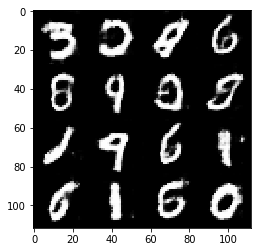

Epoch: 2, Step: 1220, G loss: 1.2919... D loss: 1.0580
Epoch: 2, Step: 1240, G loss: 0.9215... D loss: 1.1134
Epoch: 2, Step: 1260, G loss: 1.2749... D loss: 0.9899
Epoch: 2, Step: 1280, G loss: 1.3226... D loss: 1.1611
Epoch: 2, Step: 1300, G loss: 1.8298... D loss: 1.1235


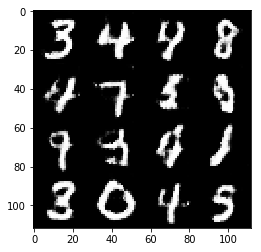

Epoch: 2, Step: 1320, G loss: 0.8859... D loss: 1.0868
Epoch: 2, Step: 1340, G loss: 1.1980... D loss: 1.0695
Epoch: 2, Step: 1360, G loss: 1.1893... D loss: 1.0870
Epoch: 2, Step: 1380, G loss: 1.0819... D loss: 1.1429
Epoch: 2, Step: 1400, G loss: 0.9372... D loss: 0.9822


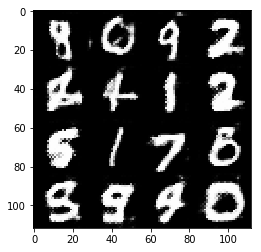

Epoch: 2, Step: 1420, G loss: 0.9968... D loss: 1.1699
Epoch: 2, Step: 1440, G loss: 1.0342... D loss: 1.1017
Epoch: 2, Step: 1460, G loss: 0.7580... D loss: 1.2022
Epoch: 2, Step: 1480, G loss: 1.3297... D loss: 1.1460
Epoch: 2, Step: 1500, G loss: 0.9414... D loss: 1.1839


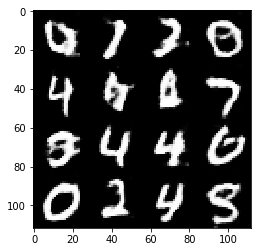

Epoch: 2, Step: 1520, G loss: 0.7520... D loss: 1.1321
Epoch: 2, Step: 1540, G loss: 0.9263... D loss: 1.1939
Epoch: 2, Step: 1560, G loss: 0.8673... D loss: 1.1726
Epoch: 2, Step: 1580, G loss: 0.9880... D loss: 1.2376
Epoch: 2, Step: 1600, G loss: 0.8972... D loss: 1.2664


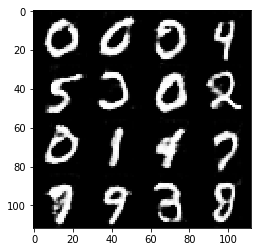

Epoch: 2, Step: 1620, G loss: 0.8969... D loss: 1.2358
Epoch: 2, Step: 1640, G loss: 0.8593... D loss: 1.1747
Epoch: 2, Step: 1660, G loss: 1.2087... D loss: 1.1013
Epoch: 2, Step: 1680, G loss: 1.0313... D loss: 1.2017
Epoch: 2, Step: 1700, G loss: 1.0753... D loss: 1.1416


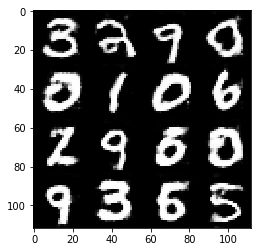

Epoch: 2, Step: 1720, G loss: 0.9103... D loss: 1.2082
Epoch: 2, Step: 1740, G loss: 0.9170... D loss: 1.1433
Epoch: 2, Step: 1760, G loss: 1.0678... D loss: 1.2782
Epoch: 2, Step: 1780, G loss: 0.8957... D loss: 1.2101
Epoch: 2, Step: 1800, G loss: 1.1856... D loss: 1.2322


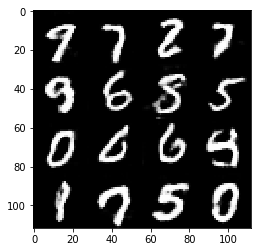

Epoch: 2, Step: 1820, G loss: 1.1008... D loss: 1.1730
Epoch: 2, Step: 1840, G loss: 0.9027... D loss: 1.1553
Epoch: 2, Step: 1860, G loss: 1.1750... D loss: 1.1866


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.01  # .008 & .005 w/ same other params also had good images
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1, Step: 20, G loss: 5.4895... D loss: 0.4948
Epoch: 1, Step: 40, G loss: 1.9635... D loss: 0.7355
Epoch: 1, Step: 60, G loss: 2.7313... D loss: 0.9209
Epoch: 1, Step: 80, G loss: 0.7978... D loss: 1.2279
Epoch: 1, Step: 100, G loss: 1.4368... D loss: 0.9776
Epoch: 1, Step: 120, G loss: 1.2753... D loss: 1.0240
Epoch: 1, Step: 140, G loss: 1.9766... D loss: 1.0110
Epoch: 1, Step: 160, G loss: 1.7965... D loss: 1.1052
Epoch: 1, Step: 180, G loss: 2.3892... D loss: 1.3655
Epoch: 1, Step: 200, G loss: 1.2461... D loss: 1.1177
Epoch: 1, Step: 220, G loss: 1.6028... D loss: 0.8926
Epoch: 1, Step: 240, G loss: 2.0960... D loss: 1.0648
Epoch: 1, Step: 260, G loss: 2.7838... D loss: 1.2181
Epoch: 1, Step: 280, G loss: 2.1477... D loss: 1.0583
Epoch: 1, Step: 300, G loss: 1.0525... D loss: 1.1166
Epoch: 1, Step: 320, G loss: 1.0941... D loss: 1.0438
Epoch: 1, Step: 340, G loss: 1.6282... D loss: 0.7511
Epoch: 1, Step: 360, G loss: 2.2927... D loss: 0.8112
Epoch: 1, Step: 380, G loss: 1.1

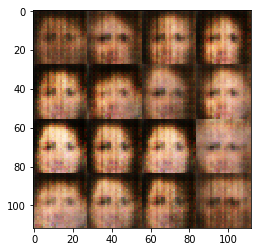

Epoch: 1, Step: 420, G loss: 2.0061... D loss: 0.9247
Epoch: 1, Step: 440, G loss: 1.6704... D loss: 0.9697
Epoch: 1, Step: 460, G loss: 1.2793... D loss: 0.9057
Epoch: 1, Step: 480, G loss: 1.9242... D loss: 0.8755
Epoch: 1, Step: 500, G loss: 1.2324... D loss: 0.9176
Epoch: 1, Step: 520, G loss: 1.0402... D loss: 1.0560
Epoch: 1, Step: 540, G loss: 1.2048... D loss: 0.8592
Epoch: 1, Step: 560, G loss: 1.8972... D loss: 0.8404
Epoch: 1, Step: 580, G loss: 1.6451... D loss: 0.9743
Epoch: 1, Step: 600, G loss: 2.0620... D loss: 1.0306
Epoch: 1, Step: 620, G loss: 1.3314... D loss: 0.8922
Epoch: 1, Step: 640, G loss: 1.1712... D loss: 1.0937
Epoch: 1, Step: 660, G loss: 2.5209... D loss: 1.0141
Epoch: 1, Step: 680, G loss: 1.4784... D loss: 0.8378
Epoch: 1, Step: 700, G loss: 2.2207... D loss: 0.9754
Epoch: 1, Step: 720, G loss: 1.6754... D loss: 1.0058
Epoch: 1, Step: 740, G loss: 0.7618... D loss: 1.1811
Epoch: 1, Step: 760, G loss: 1.3933... D loss: 1.0294
Epoch: 1, Step: 780, G loss:

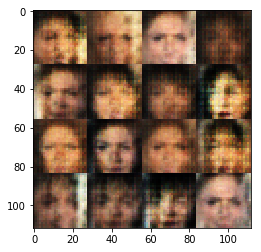

Epoch: 1, Step: 820, G loss: 1.6544... D loss: 0.7423
Epoch: 1, Step: 840, G loss: 2.5592... D loss: 1.1454
Epoch: 1, Step: 860, G loss: 1.2671... D loss: 1.0042
Epoch: 1, Step: 880, G loss: 1.4670... D loss: 1.0197
Epoch: 1, Step: 900, G loss: 1.2020... D loss: 0.9281
Epoch: 1, Step: 920, G loss: 0.8051... D loss: 1.1010
Epoch: 1, Step: 940, G loss: 2.0007... D loss: 0.8212
Epoch: 1, Step: 960, G loss: 1.1975... D loss: 0.9156
Epoch: 1, Step: 980, G loss: 1.5094... D loss: 0.8810
Epoch: 1, Step: 1000, G loss: 1.3685... D loss: 0.8129
Epoch: 1, Step: 1020, G loss: 1.3809... D loss: 0.7979
Epoch: 1, Step: 1040, G loss: 1.8887... D loss: 0.9251
Epoch: 1, Step: 1060, G loss: 2.2620... D loss: 0.8253
Epoch: 1, Step: 1080, G loss: 2.2766... D loss: 0.7835
Epoch: 1, Step: 1100, G loss: 1.3363... D loss: 0.8737
Epoch: 1, Step: 1120, G loss: 2.1307... D loss: 1.2126
Epoch: 1, Step: 1140, G loss: 1.2434... D loss: 1.0271
Epoch: 1, Step: 1160, G loss: 1.2206... D loss: 0.8450
Epoch: 1, Step: 118

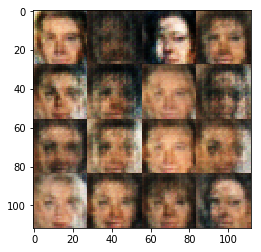

Epoch: 1, Step: 1220, G loss: 1.9586... D loss: 0.9486
Epoch: 1, Step: 1240, G loss: 1.9120... D loss: 0.9333
Epoch: 1, Step: 1260, G loss: 1.6332... D loss: 0.9044
Epoch: 1, Step: 1280, G loss: 1.7910... D loss: 0.8902
Epoch: 1, Step: 1300, G loss: 1.5506... D loss: 0.8629
Epoch: 1, Step: 1320, G loss: 2.0666... D loss: 1.1022
Epoch: 1, Step: 1340, G loss: 1.6831... D loss: 0.7827
Epoch: 1, Step: 1360, G loss: 2.4730... D loss: 1.2160
Epoch: 1, Step: 1380, G loss: 2.0249... D loss: 0.8836
Epoch: 1, Step: 1400, G loss: 1.1354... D loss: 0.9636
Epoch: 1, Step: 1420, G loss: 0.8743... D loss: 0.9851
Epoch: 1, Step: 1440, G loss: 1.3707... D loss: 0.8631
Epoch: 1, Step: 1460, G loss: 1.3543... D loss: 0.7837
Epoch: 1, Step: 1480, G loss: 1.1202... D loss: 0.9694
Epoch: 1, Step: 1500, G loss: 1.8843... D loss: 0.8929
Epoch: 1, Step: 1520, G loss: 1.9100... D loss: 0.8256
Epoch: 1, Step: 1540, G loss: 1.5417... D loss: 0.8741
Epoch: 1, Step: 1560, G loss: 2.1678... D loss: 0.7524
Epoch: 1, 

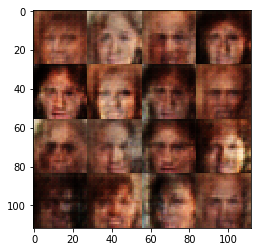

Epoch: 1, Step: 1620, G loss: 1.1825... D loss: 0.8663
Epoch: 1, Step: 1640, G loss: 3.2026... D loss: 1.3453
Epoch: 1, Step: 1660, G loss: 1.0657... D loss: 0.9429
Epoch: 1, Step: 1680, G loss: 2.5396... D loss: 0.9985
Epoch: 1, Step: 1700, G loss: 1.1461... D loss: 0.9417
Epoch: 1, Step: 1720, G loss: 2.0844... D loss: 0.8254
Epoch: 1, Step: 1740, G loss: 2.9928... D loss: 1.0142
Epoch: 1, Step: 1760, G loss: 1.2255... D loss: 0.8525
Epoch: 1, Step: 1780, G loss: 1.1017... D loss: 0.9215
Epoch: 1, Step: 1800, G loss: 1.9993... D loss: 0.9135
Epoch: 1, Step: 1820, G loss: 1.8674... D loss: 0.8531
Epoch: 1, Step: 1840, G loss: 2.8637... D loss: 1.0679
Epoch: 1, Step: 1860, G loss: 1.0643... D loss: 0.8743
Epoch: 1, Step: 1880, G loss: 0.8681... D loss: 1.0488
Epoch: 1, Step: 1900, G loss: 1.7474... D loss: 0.6616
Epoch: 1, Step: 1920, G loss: 1.2707... D loss: 0.8449
Epoch: 1, Step: 1940, G loss: 0.9744... D loss: 0.9310
Epoch: 1, Step: 1960, G loss: 2.2025... D loss: 0.7969
Epoch: 1, 

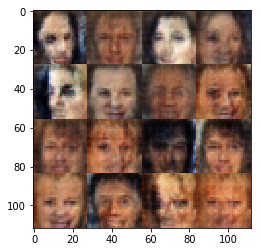

Epoch: 1, Step: 2020, G loss: 1.6711... D loss: 0.7581
Epoch: 1, Step: 2040, G loss: 1.6739... D loss: 0.7564
Epoch: 1, Step: 2060, G loss: 1.6487... D loss: 0.8521
Epoch: 1, Step: 2080, G loss: 2.1062... D loss: 0.9033
Epoch: 1, Step: 2100, G loss: 2.7128... D loss: 1.2528
Epoch: 1, Step: 2120, G loss: 1.4123... D loss: 0.8684
Epoch: 1, Step: 2140, G loss: 1.7070... D loss: 0.8361
Epoch: 1, Step: 2160, G loss: 1.6134... D loss: 0.7020
Epoch: 1, Step: 2180, G loss: 1.1348... D loss: 0.9689
Epoch: 1, Step: 2200, G loss: 1.2544... D loss: 0.8712
Epoch: 1, Step: 2220, G loss: 1.6015... D loss: 0.8453
Epoch: 1, Step: 2240, G loss: 1.1711... D loss: 0.8700
Epoch: 1, Step: 2260, G loss: 1.3902... D loss: 0.8507
Epoch: 1, Step: 2280, G loss: 1.3963... D loss: 0.7750
Epoch: 1, Step: 2300, G loss: 1.2668... D loss: 0.9230
Epoch: 1, Step: 2320, G loss: 1.9937... D loss: 0.7608
Epoch: 1, Step: 2340, G loss: 1.2398... D loss: 0.9173
Epoch: 1, Step: 2360, G loss: 1.9244... D loss: 0.8885
Epoch: 1, 

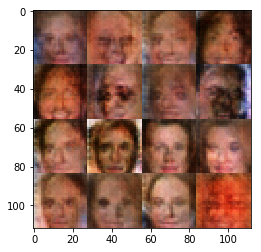

Epoch: 1, Step: 2420, G loss: 1.6118... D loss: 0.8416
Epoch: 1, Step: 2440, G loss: 1.4225... D loss: 0.9704
Epoch: 1, Step: 2460, G loss: 2.2278... D loss: 0.9743
Epoch: 1, Step: 2480, G loss: 1.4680... D loss: 0.8475
Epoch: 1, Step: 2500, G loss: 2.4822... D loss: 1.1043
Epoch: 1, Step: 2520, G loss: 1.4358... D loss: 0.8444
Epoch: 1, Step: 2540, G loss: 1.1139... D loss: 0.8770
Epoch: 1, Step: 2560, G loss: 1.9054... D loss: 0.8509
Epoch: 1, Step: 2580, G loss: 1.0565... D loss: 0.8853
Epoch: 1, Step: 2600, G loss: 0.8948... D loss: 0.9557
Epoch: 1, Step: 2620, G loss: 1.2114... D loss: 0.8002
Epoch: 1, Step: 2640, G loss: 1.3937... D loss: 0.8604
Epoch: 1, Step: 2660, G loss: 1.7763... D loss: 0.8292
Epoch: 1, Step: 2680, G loss: 2.5628... D loss: 0.9496
Epoch: 1, Step: 2700, G loss: 1.1360... D loss: 0.9382
Epoch: 1, Step: 2720, G loss: 2.6582... D loss: 1.1777
Epoch: 1, Step: 2740, G loss: 2.1068... D loss: 1.0594
Epoch: 1, Step: 2760, G loss: 1.9024... D loss: 0.7382
Epoch: 1, 

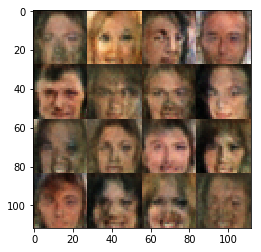

Epoch: 1, Step: 2820, G loss: 2.4185... D loss: 1.1528
Epoch: 1, Step: 2840, G loss: 0.9850... D loss: 0.9508
Epoch: 1, Step: 2860, G loss: 0.7724... D loss: 1.0802
Epoch: 1, Step: 2880, G loss: 1.9524... D loss: 0.7736
Epoch: 1, Step: 2900, G loss: 1.9250... D loss: 0.8510
Epoch: 1, Step: 2920, G loss: 2.2256... D loss: 1.1034
Epoch: 1, Step: 2940, G loss: 1.4356... D loss: 0.9193
Epoch: 1, Step: 2960, G loss: 2.0563... D loss: 0.8418
Epoch: 1, Step: 2980, G loss: 1.3268... D loss: 0.8389
Epoch: 1, Step: 3000, G loss: 1.4452... D loss: 0.8277
Epoch: 1, Step: 3020, G loss: 1.1314... D loss: 0.9188
Epoch: 1, Step: 3040, G loss: 1.6856... D loss: 0.9217
Epoch: 1, Step: 3060, G loss: 1.0978... D loss: 0.8755
Epoch: 1, Step: 3080, G loss: 1.2292... D loss: 0.9065
Epoch: 1, Step: 3100, G loss: 1.1047... D loss: 0.8741
Epoch: 1, Step: 3120, G loss: 1.4109... D loss: 0.9128
Epoch: 1, Step: 3140, G loss: 1.9641... D loss: 0.8733
Epoch: 1, Step: 3160, G loss: 1.4949... D loss: 0.7509
Epoch: 1, 

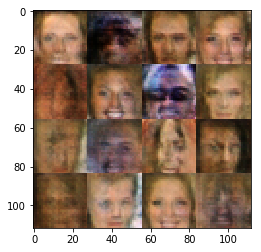

Epoch: 1, Step: 3220, G loss: 1.8784... D loss: 0.9256
Epoch: 1, Step: 3240, G loss: 1.2477... D loss: 0.8832
Epoch: 1, Step: 3260, G loss: 0.9904... D loss: 0.9174
Epoch: 1, Step: 3280, G loss: 1.2389... D loss: 0.9130
Epoch: 1, Step: 3300, G loss: 0.8391... D loss: 1.0319
Epoch: 1, Step: 3320, G loss: 1.4102... D loss: 0.8126
Epoch: 1, Step: 3340, G loss: 1.1162... D loss: 0.9555
Epoch: 1, Step: 3360, G loss: 1.3771... D loss: 0.9202
Epoch: 1, Step: 3380, G loss: 1.1011... D loss: 0.9026
Epoch: 1, Step: 3400, G loss: 2.3817... D loss: 1.1267
Epoch: 1, Step: 3420, G loss: 1.9005... D loss: 0.8876
Epoch: 1, Step: 3440, G loss: 0.8187... D loss: 1.0829
Epoch: 1, Step: 3460, G loss: 1.5342... D loss: 0.8461
Epoch: 1, Step: 3480, G loss: 1.1896... D loss: 0.8238
Epoch: 1, Step: 3500, G loss: 1.3427... D loss: 0.9138
Epoch: 1, Step: 3520, G loss: 2.1486... D loss: 0.9485
Epoch: 1, Step: 3540, G loss: 1.1990... D loss: 0.9233
Epoch: 1, Step: 3560, G loss: 1.1534... D loss: 0.9213
Epoch: 1, 

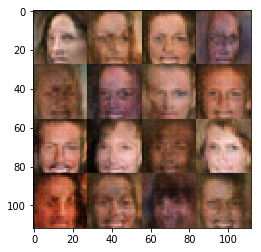

Epoch: 1, Step: 3620, G loss: 2.3745... D loss: 1.1737
Epoch: 1, Step: 3640, G loss: 1.3912... D loss: 0.8998
Epoch: 1, Step: 3660, G loss: 1.0002... D loss: 0.9496
Epoch: 1, Step: 3680, G loss: 1.4277... D loss: 0.9103
Epoch: 1, Step: 3700, G loss: 2.0242... D loss: 0.9270
Epoch: 1, Step: 3720, G loss: 1.5996... D loss: 0.8894
Epoch: 1, Step: 3740, G loss: 1.3121... D loss: 0.8358
Epoch: 1, Step: 3760, G loss: 1.7328... D loss: 0.8886
Epoch: 1, Step: 3780, G loss: 1.6991... D loss: 0.8636
Epoch: 1, Step: 3800, G loss: 3.3023... D loss: 1.7954
Epoch: 1, Step: 3820, G loss: 1.7175... D loss: 0.8534
Epoch: 1, Step: 3840, G loss: 1.9228... D loss: 1.0017
Epoch: 1, Step: 3860, G loss: 1.1964... D loss: 0.8889
Epoch: 1, Step: 3880, G loss: 1.2954... D loss: 0.8676
Epoch: 1, Step: 3900, G loss: 0.9081... D loss: 1.0102
Epoch: 1, Step: 3920, G loss: 1.1250... D loss: 0.9759
Epoch: 1, Step: 3940, G loss: 1.0983... D loss: 0.9983
Epoch: 1, Step: 3960, G loss: 1.5152... D loss: 0.8436
Epoch: 1, 

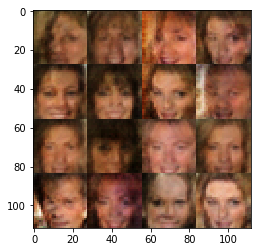

Epoch: 1, Step: 4020, G loss: 0.6667... D loss: 1.1716
Epoch: 1, Step: 4040, G loss: 1.6515... D loss: 0.9332
Epoch: 1, Step: 4060, G loss: 1.1450... D loss: 0.8910
Epoch: 1, Step: 4080, G loss: 1.3174... D loss: 0.9391
Epoch: 1, Step: 4100, G loss: 1.8404... D loss: 1.0530
Epoch: 1, Step: 4120, G loss: 1.1629... D loss: 0.9209
Epoch: 1, Step: 4140, G loss: 1.0833... D loss: 1.0016
Epoch: 1, Step: 4160, G loss: 1.8029... D loss: 0.8663
Epoch: 1, Step: 4180, G loss: 0.9713... D loss: 0.9389
Epoch: 1, Step: 4200, G loss: 0.9161... D loss: 0.9877
Epoch: 1, Step: 4220, G loss: 1.3087... D loss: 0.9496
Epoch: 1, Step: 4240, G loss: 1.8332... D loss: 1.0659
Epoch: 1, Step: 4260, G loss: 1.1168... D loss: 0.9675
Epoch: 1, Step: 4280, G loss: 1.5582... D loss: 0.8761
Epoch: 1, Step: 4300, G loss: 0.9067... D loss: 1.0604
Epoch: 1, Step: 4320, G loss: 1.3422... D loss: 0.8640
Epoch: 1, Step: 4340, G loss: 1.1832... D loss: 0.9669
Epoch: 1, Step: 4360, G loss: 0.9797... D loss: 0.9313
Epoch: 1, 

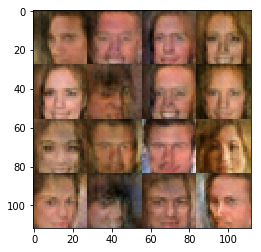

Epoch: 1, Step: 4420, G loss: 0.9260... D loss: 0.9754
Epoch: 1, Step: 4440, G loss: 1.3971... D loss: 0.8625
Epoch: 1, Step: 4460, G loss: 1.3171... D loss: 0.9209
Epoch: 1, Step: 4480, G loss: 0.7226... D loss: 1.1162
Epoch: 1, Step: 4500, G loss: 1.4182... D loss: 1.0707
Epoch: 1, Step: 4520, G loss: 1.1418... D loss: 0.9153
Epoch: 1, Step: 4540, G loss: 1.9768... D loss: 0.8515
Epoch: 1, Step: 4560, G loss: 1.1318... D loss: 0.9128
Epoch: 1, Step: 4580, G loss: 1.8541... D loss: 0.9638
Epoch: 1, Step: 4600, G loss: 1.4565... D loss: 0.9460
Epoch: 1, Step: 4620, G loss: 1.3334... D loss: 0.9268
Epoch: 1, Step: 4640, G loss: 0.6433... D loss: 1.1707
Epoch: 1, Step: 4660, G loss: 1.8886... D loss: 1.0619
Epoch: 1, Step: 4680, G loss: 1.6186... D loss: 0.9347
Epoch: 1, Step: 4700, G loss: 1.7037... D loss: 0.9582
Epoch: 1, Step: 4720, G loss: 1.4296... D loss: 0.8925
Epoch: 1, Step: 4740, G loss: 1.7009... D loss: 1.0244
Epoch: 1, Step: 4760, G loss: 1.7544... D loss: 1.0410
Epoch: 1, 

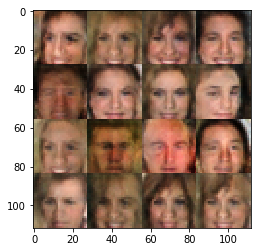

Epoch: 1, Step: 4820, G loss: 1.1334... D loss: 0.9416
Epoch: 1, Step: 4840, G loss: 1.2078... D loss: 0.9211
Epoch: 1, Step: 4860, G loss: 1.1901... D loss: 0.8977
Epoch: 1, Step: 4880, G loss: 1.2251... D loss: 0.9930
Epoch: 1, Step: 4900, G loss: 0.8394... D loss: 1.1695
Epoch: 1, Step: 4920, G loss: 1.4191... D loss: 0.9770
Epoch: 1, Step: 4940, G loss: 1.6950... D loss: 0.9151
Epoch: 1, Step: 4960, G loss: 0.9991... D loss: 1.0490
Epoch: 1, Step: 4980, G loss: 1.2511... D loss: 0.9680
Epoch: 1, Step: 5000, G loss: 1.2367... D loss: 1.0106
Epoch: 1, Step: 5020, G loss: 1.9097... D loss: 1.0670
Epoch: 1, Step: 5040, G loss: 0.9142... D loss: 1.0797
Epoch: 1, Step: 5060, G loss: 1.0284... D loss: 1.1330
Epoch: 1, Step: 5080, G loss: 1.3153... D loss: 1.0306
Epoch: 1, Step: 5100, G loss: 1.2202... D loss: 0.9126
Epoch: 1, Step: 5120, G loss: 1.3308... D loss: 0.9547
Epoch: 1, Step: 5140, G loss: 1.1980... D loss: 0.9361
Epoch: 1, Step: 5160, G loss: 0.8934... D loss: 1.0299
Epoch: 1, 

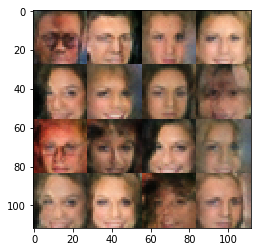

Epoch: 1, Step: 5220, G loss: 1.3767... D loss: 0.9469
Epoch: 1, Step: 5240, G loss: 1.0570... D loss: 0.9343
Epoch: 1, Step: 5260, G loss: 1.4019... D loss: 0.9208
Epoch: 1, Step: 5280, G loss: 0.8187... D loss: 1.1312
Epoch: 1, Step: 5300, G loss: 1.6520... D loss: 1.0046
Epoch: 1, Step: 5320, G loss: 1.3591... D loss: 0.8976
Epoch: 1, Step: 5340, G loss: 0.9504... D loss: 1.0281
Epoch: 1, Step: 5360, G loss: 1.6566... D loss: 0.9745
Epoch: 1, Step: 5380, G loss: 2.2422... D loss: 1.1250
Epoch: 1, Step: 5400, G loss: 0.8927... D loss: 1.0301
Epoch: 1, Step: 5420, G loss: 1.2901... D loss: 0.9184
Epoch: 1, Step: 5440, G loss: 1.2996... D loss: 1.0115
Epoch: 1, Step: 5460, G loss: 1.1154... D loss: 0.9280
Epoch: 1, Step: 5480, G loss: 0.8162... D loss: 1.0712
Epoch: 1, Step: 5500, G loss: 1.3621... D loss: 1.1475
Epoch: 1, Step: 5520, G loss: 0.9528... D loss: 1.0723
Epoch: 1, Step: 5540, G loss: 1.0750... D loss: 0.9910
Epoch: 1, Step: 5560, G loss: 1.0927... D loss: 0.9707
Epoch: 1, 

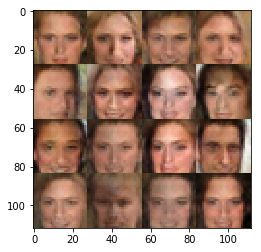

Epoch: 1, Step: 5620, G loss: 1.3484... D loss: 1.0678
Epoch: 1, Step: 5640, G loss: 2.0336... D loss: 1.0310
Epoch: 1, Step: 5660, G loss: 1.3971... D loss: 1.0020
Epoch: 1, Step: 5680, G loss: 0.9442... D loss: 1.0361
Epoch: 1, Step: 5700, G loss: 1.2282... D loss: 1.1024
Epoch: 1, Step: 5720, G loss: 0.9956... D loss: 1.0069
Epoch: 1, Step: 5740, G loss: 1.2451... D loss: 0.9755
Epoch: 1, Step: 5760, G loss: 1.7682... D loss: 1.1106
Epoch: 1, Step: 5780, G loss: 1.2271... D loss: 1.0218
Epoch: 1, Step: 5800, G loss: 1.0443... D loss: 1.0222
Epoch: 1, Step: 5820, G loss: 1.2357... D loss: 1.0800
Epoch: 1, Step: 5840, G loss: 0.8699... D loss: 1.1097
Epoch: 1, Step: 5860, G loss: 0.9478... D loss: 1.0334
Epoch: 1, Step: 5880, G loss: 1.5141... D loss: 0.9715
Epoch: 1, Step: 5900, G loss: 1.4434... D loss: 0.9286
Epoch: 1, Step: 5920, G loss: 1.9984... D loss: 1.1550
Epoch: 1, Step: 5940, G loss: 1.1288... D loss: 1.0077
Epoch: 1, Step: 5960, G loss: 0.9662... D loss: 1.0847
Epoch: 1, 

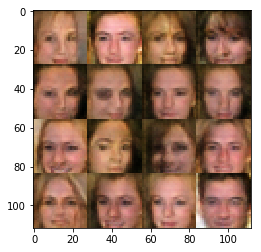

Epoch: 1, Step: 6020, G loss: 1.1060... D loss: 1.0747
Epoch: 1, Step: 6040, G loss: 1.2201... D loss: 1.0128
Epoch: 1, Step: 6060, G loss: 0.9316... D loss: 1.0253
Epoch: 1, Step: 6080, G loss: 1.0316... D loss: 1.0546


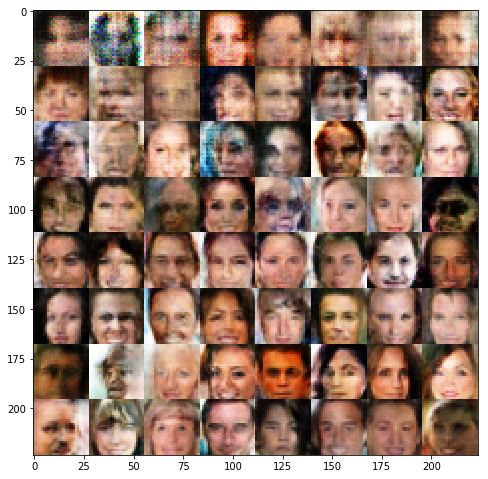

Epoch: 1, Step: 6100, G loss: 1.7407... D loss: 1.1390
Epoch: 1, Step: 6120, G loss: 0.9744... D loss: 1.0547
Epoch: 1, Step: 6140, G loss: 1.0349... D loss: 1.0867
Epoch: 1, Step: 6160, G loss: 1.3074... D loss: 1.0193
Epoch: 1, Step: 6180, G loss: 1.2497... D loss: 1.0568
Epoch: 1, Step: 6200, G loss: 1.3305... D loss: 0.8957
Epoch: 1, Step: 6220, G loss: 1.1155... D loss: 1.0648
Epoch: 1, Step: 6240, G loss: 1.1539... D loss: 1.0044
Epoch: 1, Step: 6260, G loss: 1.3712... D loss: 1.1253
Epoch: 1, Step: 6280, G loss: 0.8331... D loss: 1.0712
Epoch: 1, Step: 6300, G loss: 1.1751... D loss: 1.0414
Epoch: 1, Step: 6320, G loss: 0.8725... D loss: 1.1399


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.